In [1]:
import os
import numpy as np
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

In [2]:
seed_list = [7, 14, 21]
dataset_list = [2, 12, 32, 100]
source_list = [12, 32, 100]
sample_list = [64, 256, 1024, 4096, 16384, 32768]
w_list = ['wpca', 'w0', 'w1']
aux_list = ['aux', 'aux0', 'aux1']
isi_list = ['isi', 'isi0', 'isi1']

datadir = '/Users/xli77/Documents/MISA/MISA-data/torch'

loss = np.zeros([len(dataset_list), len(source_list), len(sample_list), len(seed_list), len(w_list) ])
isi = np.zeros([len(dataset_list), len(source_list), len(sample_list), len(seed_list), len(w_list) ])

for i, n_dataset in enumerate(dataset_list):
    for j, n_source in enumerate(source_list):
        if (n_dataset==32 and n_source==100) or (n_dataset==100 and n_source==32) or (n_dataset==100 and n_source==100):
            continue
        for k, n_sample in enumerate(sample_list):
            if (n_source > n_sample) or (n_dataset > n_sample): # (n_sample==64 and n_dataset==100 and n_source==12):
                continue
            for m, w in enumerate(w_list):
                for n, seed in enumerate(seed_list):
                    datapath=os.path.join(datadir, f'out-siva_dataset{n_dataset}_source{n_source}_sample{n_sample}_seed{seed}_{w}')
                    loss[i,j,k,m,n]=float(sio.loadmat(datapath)[aux_list[m]][1,0])
                    isi[i,j,k,m,n]=float(sio.loadmat(datapath)[isi_list[m]])

In [3]:
isi_py = np.load("/Users/xli77/Documents/MISA-pytorch/run/checkpoints/sim-siva/misa_sim-siva_isi_py.npy")

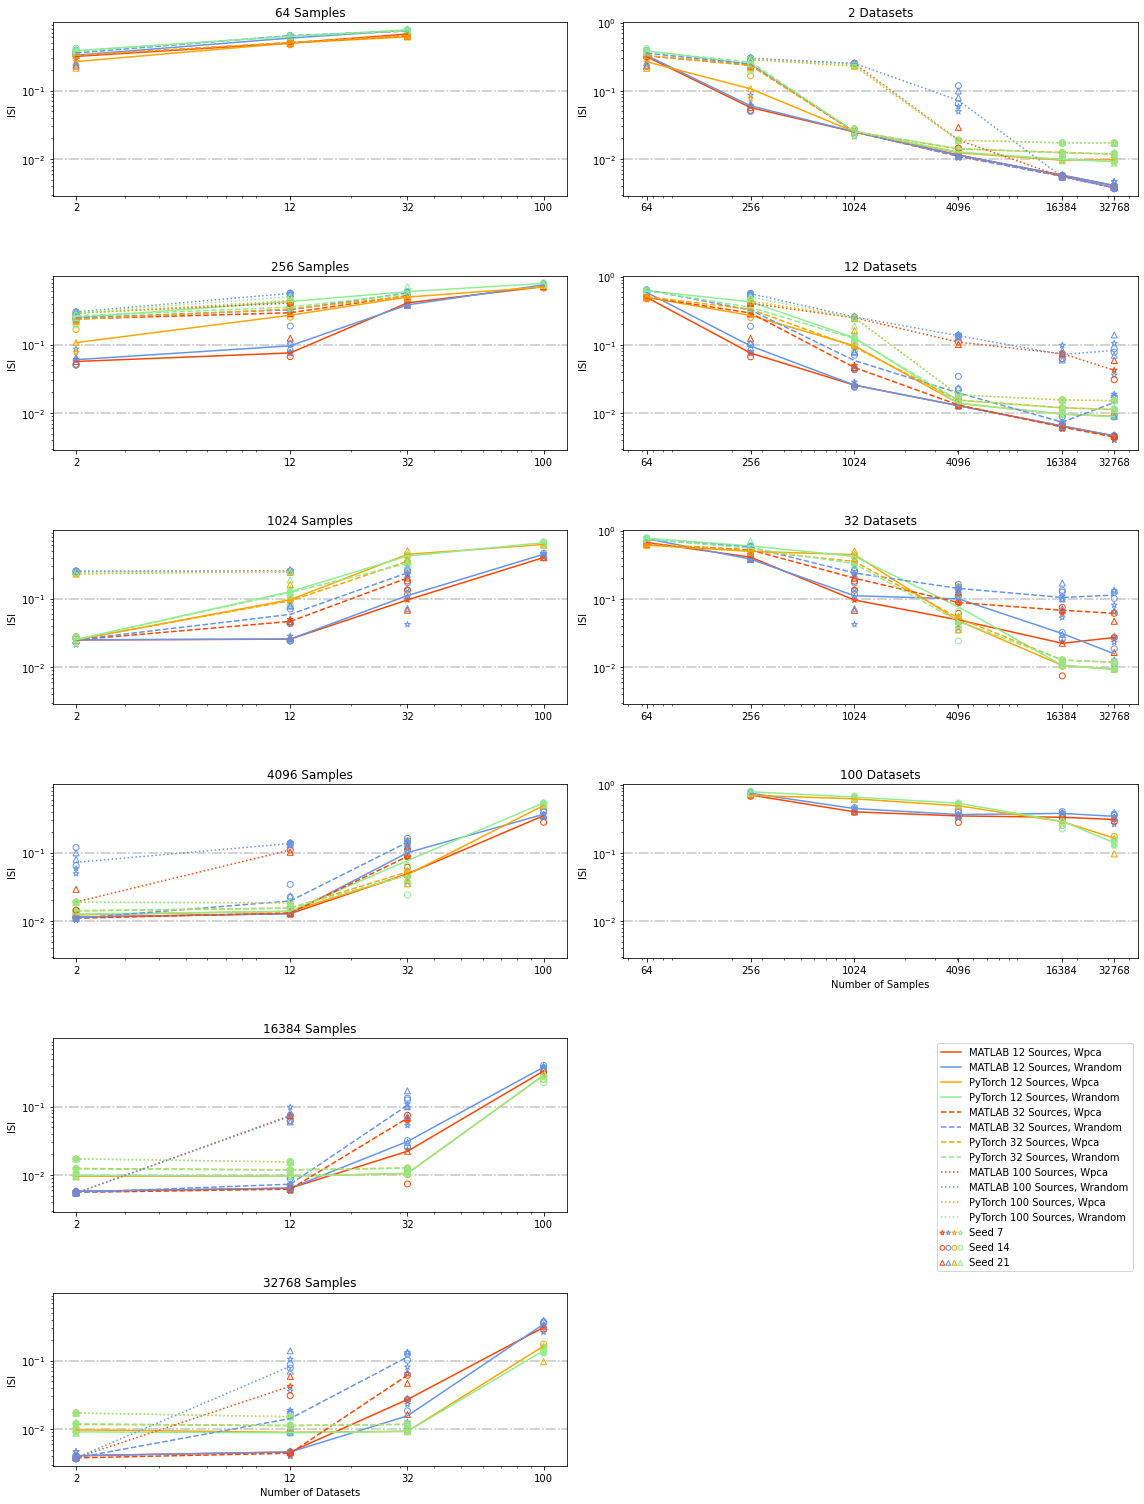

In [4]:
fig, axes = plt.subplots(len(sample_list),2,figsize=(16,3.5*len(sample_list)))
color_list = ['cornflowerblue', 'orangered', 'lightgreen', 'orange']
linestyle_list = ['solid', 'dashed', 'dotted']
marker_list = ['*', 'o', '^']

for i, m in enumerate(sample_list):
    p = []
    for j, k in enumerate(source_list):
        # MATLAB
        isi_pca = isi[:,j,i,0,:]
        isi_rand = np.concatenate([isi[:,j,i,1,:], isi[:,j,i,2,:]], axis=1)
        isi_median_pca = np.median(isi_pca, axis=1)
        isi_median_rand = np.median(isi_rand, axis=1)

        ind = isi_median_pca!=0
        isi_valid_pca = isi_pca[ind,:]
        isi_valid_rand = isi_rand[ind,:]
        isi_median_valid_pca = isi_median_pca[ind]
        isi_median_valid_rand = isi_median_rand[ind]
        sample_arr = np.asarray(dataset_list) 
        sample_arr_valid = sample_arr[ind]
        
        # Python
        isi_py_pca = isi_py[:,j,i,0,:]
        isi_py_rand = np.concatenate([isi_py[:,j,i,1,:], isi_py[:,j,i,2,:]], axis=1)
        isi_py_median_pca = np.median(isi_py_pca, axis=1)
        isi_py_median_rand = np.median(isi_py_rand, axis=1)

        ind_py = isi_py_median_pca!=0
        isi_py_valid_pca = isi_py_pca[ind,:]
        isi_py_valid_rand = isi_py_rand[ind,:]
        isi_py_median_valid_pca = isi_py_median_pca[ind]
        isi_py_median_valid_rand = isi_py_median_rand[ind]
        sample_arr_py = np.asarray(dataset_list) 
        sample_arr_valid_py = sample_arr_py[ind_py]
        
        axes[i,0].axhline(y=0.1, linestyle='-.', color='lightgray', zorder=-1)
        axes[i,0].axhline(y=0.01, linestyle='-.', color='lightgray', zorder=-1)

        p1, = axes[i,0].plot(sample_arr_valid, isi_median_valid_pca, linestyle=linestyle_list[j], color=color_list[1], label=f'MATLAB {k} Sources, Wpca') # Wpca
        p2, = axes[i,0].plot(sample_arr_valid, isi_median_valid_rand, linestyle=linestyle_list[j], color=color_list[0], label=f'MATLAB {k} Sources, Wrandom') # Wrandom
        p3, = axes[i,0].plot(sample_arr_valid_py, isi_py_median_valid_pca, linestyle=linestyle_list[j], color=color_list[3], label=f'PyTorch {k} Sources, Wpca') # Wpca
        p4, = axes[i,0].plot(sample_arr_valid_py, isi_py_median_valid_rand, linestyle=linestyle_list[j], color=color_list[2], label=f'PyTorch {k} Sources, Wrandom') # Wrandom

        p.append(p1)
        p.append(p2)
        p.append(p3)
        p.append(p4)

        for l, s in enumerate(seed_list):
            if j==2:
                p5 = axes[i,0].scatter(sample_arr_valid, isi_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[1], label=f'Seed {s}')
                p6 = axes[i,0].scatter(sample_arr_valid, isi_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[0], label=f'Seed {s}')
                p7 = axes[i,0].scatter(sample_arr_valid_py, isi_py_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[3], label=f'Seed {s}')
                p8 = axes[i,0].scatter(sample_arr_valid_py, isi_py_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[2], label=f'Seed {s}')
                axes[i,0].scatter(sample_arr_valid, isi_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])
                axes[i,0].scatter(sample_arr_valid_py, isi_py_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[2])
                p.append((p5, p6, p7, p8))
            else:
                axes[i,0].scatter(sample_arr_valid, isi_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[1])
                axes[i,0].scatter(sample_arr_valid, isi_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])
                axes[i,0].scatter(sample_arr_valid, isi_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])
                axes[i,0].scatter(sample_arr_valid_py, isi_py_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[3])
                axes[i,0].scatter(sample_arr_valid_py, isi_py_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[2])
                axes[i,0].scatter(sample_arr_valid_py, isi_py_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[2])

        axes[i,0].set_xscale('log')
        axes[i,0].set_yscale('log')
        axes[i,0].set_xticks(dataset_list)
        axes[i,0].set_xticklabels(dataset_list)
        axes[i,0].set_title(f"{m} Samples")
        axes[i,0].set_ylabel("ISI")

        if i < 4:
            isi_pca = isi[i,j,:,0,:]
            isi_rand = np.concatenate([isi[i,j,:,1,:], isi[i,j,:,2,:]], axis=1)
            isi_median_pca = np.median(isi_pca, axis=1)
            isi_median_rand = np.median(isi_rand, axis=1)

            ind = isi_median_pca!=0
            isi_valid_pca = isi_pca[ind,:]
            isi_valid_rand = isi_rand[ind,:]
            isi_median_valid_pca = isi_median_pca[ind]
            isi_median_valid_rand = isi_median_rand[ind]
            sample_arr = np.asarray(sample_list) 
            sample_arr_valid = sample_arr[ind]

            isi_py_pca = isi_py[i,j,:,0,:]
            isi_py_rand = np.concatenate([isi_py[i,j,:,1,:], isi_py[i,j,:,2,:]], axis=1)
            isi_py_median_pca = np.median(isi_py_pca, axis=1)
            isi_py_median_rand = np.median(isi_py_rand, axis=1)

            ind_py = isi_py_median_pca!=0
            isi_py_valid_pca = isi_py_pca[ind,:]
            isi_py_valid_rand = isi_py_rand[ind,:]
            isi_py_median_valid_pca = isi_py_median_pca[ind]
            isi_py_median_valid_rand = isi_py_median_rand[ind]
            sample_arr_py = np.asarray(sample_list) 
            sample_arr_valid_py = sample_arr_py[ind_py]

            axes[i,1].axhline(y=0.1, linestyle='-.', color='lightgray', zorder=-1)
            axes[i,1].axhline(y=0.01, linestyle='-.', color='lightgray', zorder=-1)

            axes[i,1].plot(sample_arr_valid, isi_median_valid_pca, linestyle=linestyle_list[j], color=color_list[1], label=f'MATLAB {k} Sources, Wpca') # Wpca
            axes[i,1].plot(sample_arr_valid, isi_median_valid_rand, linestyle=linestyle_list[j], color=color_list[0], label=f'MATLAB {k} Sources, Wrandom') # Wrandom
            axes[i,1].plot(sample_arr_valid_py, isi_py_median_valid_pca, linestyle=linestyle_list[j], color=color_list[3], label=f'PyTorch {k} Sources, Wpca') # Wpca
            axes[i,1].plot(sample_arr_valid_py, isi_py_median_valid_rand, linestyle=linestyle_list[j], color=color_list[2], label=f'PyTorch {k} Sources, Wrandom') # Wrandom

            for l, s in enumerate(seed_list):
                if j==2:
                    axes[i,1].scatter(sample_arr_valid, isi_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[1], label=f'Seed {s}')
                    axes[i,1].scatter(sample_arr_valid, isi_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[0], label=f'Seed {s}')
                    axes[i,1].scatter(sample_arr_valid, isi_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])
                    axes[i,1].scatter(sample_arr_valid_py, isi_py_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[3], label=f'Seed {s}')
                    axes[i,1].scatter(sample_arr_valid_py, isi_py_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[2], label=f'Seed {s}')
                    axes[i,1].scatter(sample_arr_valid_py, isi_py_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[2])
                else:
                    axes[i,1].scatter(sample_arr_valid, isi_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[1])
                    axes[i,1].scatter(sample_arr_valid, isi_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])
                    axes[i,1].scatter(sample_arr_valid, isi_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])
                    axes[i,1].scatter(sample_arr_valid_py, isi_py_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[3])
                    axes[i,1].scatter(sample_arr_valid_py, isi_py_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[2])
                    axes[i,1].scatter(sample_arr_valid_py, isi_py_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[2])

            axes[i,1].set_xscale('log')
            axes[i,1].set_yscale('log')
            axes[i,1].set_xticks(sample_list)
            axes[i,1].set_xticklabels(sample_list)
            axes[i,1].set_title(f"{dataset_list[i]} Datasets")
            axes[i,1].set_ylabel("ISI")

axes[-1,0].set_xlabel("Number of Datasets")
axes[3,1].set_xlabel("Number of Samples")

axes[-2,1].legend(p, ['MATLAB 12 Sources, Wpca', 'MATLAB 12 Sources, Wrandom',
    'PyTorch 12 Sources, Wpca', 'PyTorch 12 Sources, Wrandom',
    'MATLAB 32 Sources, Wpca', 'MATLAB 32 Sources, Wrandom',
    'PyTorch 32 Sources, Wpca', 'PyTorch 32 Sources, Wrandom',
    'MATLAB 100 Sources, Wpca', 'MATLAB 100 Sources, Wrandom',
    'PyTorch 100 Sources, Wpca', 'PyTorch 100 Sources, Wrandom', 
    'Seed 7', 'Seed 14', 'Seed 21'],
    scatterpoints=1, numpoints=1, markerscale=0.8, handler_map={tuple: HandlerTuple(ndivide=None)}) #bbox_to_anchor=(1.4, 0.9)

axes[4,1].axis('off')
axes[5,1].axis('off')

ylim_lower=np.zeros(len(sample_list))
ylim_upper=np.zeros(len(sample_list))
for i in range(len(sample_list)):
    ylim_lower[i] = axes[i,0].get_ylim()[0]
    ylim_upper[i] = axes[i,0].get_ylim()[1]

xlim = axes[1,0].get_xlim()
ylim = (np.min(ylim_lower), np.max(ylim_upper))
for i in range(len(sample_list)):
    axes[i,0].set_xlim(xlim)
    axes[i,0].set_ylim(ylim)

ylim_lower=np.zeros(len(dataset_list))
ylim_upper=np.zeros(len(dataset_list))
for i in range(len(dataset_list)):
    ylim_lower[i] = axes[i,1].get_ylim()[0]
    ylim_upper[i] = axes[i,1].get_ylim()[1]

xlim = axes[0,1].get_xlim()
ylim = (np.min(ylim_lower), np.max(ylim_upper))
for i in range(len(dataset_list)):
    axes[i,1].set_xlim(xlim)
    axes[i,1].set_ylim(ylim)

plt.tight_layout()
plt.savefig("/Users/xli77/Documents/MISA-pytorch/figures/ISI.pdf", dpi=300)